В цьому домашньому завданні кожне завдання оцінюється по 10 балів.

 **Завдання 1.** Після перегляду лекцій про поняття функії, вступ до лінійної алгебри і мат. формулювання лін. регресії знайдіть найкращу лінію для прогнозу `charges` за `age` **для некурців** (датафрейм `non_smoker_df`) з допомогою

1. Методу МНК (з використанням тільки `numpy`, без `scikit learn`)

2. Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.
3. З `scikit-learn.LinearRegression`. Тут зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись `X.to_frame()` щоб конвертувати колонку в датафрейм.

Для кожного методу
- знайдіть і виведіть коефіцієнти моделі
- обчисліть прогнози моделі і збережіть в окрему змінну
- порахуйте точність прогнозу RMSE  

Для градієнтного спуску виведіть графік помилки в залежності від ітерації.

А також побудуйте на одному графіку дані `age` проти `charges` в вигляді діаграми розсіювання і всі три лінії регресії, знайдені кожним з методів (для град. спуску оберіть варіант з тим learning rate, який виявився найкращим).

Зробіть висновки, чи відрізняються результати моделей?
Чи є знайдені параметри моделі близькими до ваших найкращих припущень?

In [164]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [165]:
medical_df = pd.read_csv('medical-charges.csv') # замініть на ваш шлях до файлу
non_smoker_df = medical_df[medical_df.smoker == 'no']

In [166]:
non_smoker_df.head()

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


## Least Squares Method

In [167]:
# array: intercept + age
intercept_and_age = non_smoker_df.age
intercept_and_age = np.c_[np.ones((intercept_and_age.shape[0], 1)), intercept_and_age]
intercept_and_age

array([[ 1., 18.],
       [ 1., 28.],
       [ 1., 33.],
       ...,
       [ 1., 18.],
       [ 1., 18.],
       [ 1., 21.]])

In [168]:
#### 1. Least squares method
def least_squares(x, y):
  coefs = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
  return coefs

In [169]:
# apply LS method
coefs_lsm = least_squares(intercept_and_age, non_smoker_df.charges)

print (f'Coefficients found wit LSM: {coefs_lsm}')

Coefficients found wit LSM: [-2091.42055657   267.24891283]


In [170]:
# predict using LS method: X*theta
prediction_lsm = np.dot(intercept_and_age, coefs_lsm)

In [171]:
# RMSE (Root mean square error) for Least squares method
rmse_lsm = np.sqrt(mean_squared_error(non_smoker_df.charges, prediction_lsm))
print(f'RMSE for Least squares method: {rmse_lsm}')

RMSE for Least squares method: 4662.505766636395


In [172]:
# additional metrics: R^2, MAE (Mean Absolute Error)
r2_lsm = r2_score(non_smoker_df.charges, prediction_lsm)
mae_lsm = mean_absolute_error(non_smoker_df.charges, prediction_lsm)

print(f'R^2 for Least squares method: {r2_lsm}')
print(f'MAE for Least squares method: {mae_lsm}')

R^2 for Least squares method: 0.3943171632425906
MAE for Least squares method: 2580.5232282116117


In [173]:
# statistics to compare the errors with:
np.mean(non_smoker_df.charges), np.std(non_smoker_df.charges)

(np.float64(8434.268297856204), 5990.964530287611)

## Full-batch Gradient Descent

In [174]:
#### 2. Full-batch gradient descent
  # Params:
  # x: numpy ndarray, shape: (n,)
  # y: numpy ndarray, shape: (n,)
def full_batch_gradient_descent(x, y, lr=0.1, epochs=1000):
    m = 0.0
    b = 0.0
    errors = []
    for i in range(epochs):
        y_forecast= m * x + b
        error = y_forecast - y
        errors.append(sum(error**2))
        m_gradient = (2/len(y)) * np.dot(error, x)
        b_gradient = (2/len(y)) * np.sum(error)
        #print(f'epoch: {i}')
        #print(f'm old: {m}')
        m = m - lr * m_gradient
        b = b - lr * b_gradient
        #print(f'm gradient: {m_gradient}')
        #print(f'm new: {m}')
    return m, b, errors

In [175]:
# Experiment 1: lr1 = 0.0001
lr1_fbgd = 0.0001
m_fbgd_lr1, b_fbgd_lr1, errors_lr1 = full_batch_gradient_descent(non_smoker_df.age.values, non_smoker_df.charges.values, lr=lr1_fbgd) # non_smoker_df.age.values - pandas Series into numpy array
prediction_fbgd_lr1 = m_fbgd_lr1 * non_smoker_df.age.values + b_fbgd_lr1

print (f'Coefficients found wit Full-Batch Grad. Descent lr={lr1_fbgd} (b, m): {b_fbgd_lr1}, {m_fbgd_lr1}')

Coefficients found wit Full-Batch Grad. Descent lr=0.0001 (b, m): -41.98126853149978, 221.1045843794301


In [176]:
# Experiment 2: lr2 = 0.00001
lr2_fbgd = 0.00001
m_fbgd_lr2, b_fbgd_lr2, errors_lr2 = full_batch_gradient_descent(non_smoker_df.age.values, non_smoker_df.charges.values, lr=lr2_fbgd)
prediction_fbgd_lr2 = m_fbgd_lr2 * non_smoker_df.age.values + b_fbgd_lr2

print (f'Coefficients found wit Full-Batch Grad. Descent lr={lr2_fbgd} (b, m): {b_fbgd_lr2}, {m_fbgd_lr2}')

Coefficients found wit Full-Batch Grad. Descent lr=1e-05 (b, m): 0.21300652799863293, 220.15455551129122


In [177]:
# Experiment 3: lr3 = 0.000001
lr3_fbgd = 0.000001
m_fbgd_lr3, b_fbgd_lr3, errors_lr3 = full_batch_gradient_descent(non_smoker_df.age.values, non_smoker_df.charges.values, lr=lr3_fbgd) # non_smoker_df.age.values - pandas Series into numpy array
prediction_fbgd_lr3 = m_fbgd_lr3 * non_smoker_df.age.values + b_fbgd_lr3

print (f'Coefficients found wit Full-Batch Grad. Descent lr={lr3_fbgd} (b, m): {b_fbgd_lr3}, {m_fbgd_lr3}')

Coefficients found wit Full-Batch Grad. Descent lr=1e-06 (b, m): 4.33124916239435, 213.4575690658104


In [178]:
# RMSE (Root mean square error) for Full batch gradient descent (lr1-lr3)
rmse_fbgd_lr1 = np.sqrt(mean_squared_error(non_smoker_df.charges, prediction_fbgd_lr1))
rmse_fbgd_lr2 = np.sqrt(mean_squared_error(non_smoker_df.charges, prediction_fbgd_lr2))
rmse_fbgd_lr3 = np.sqrt(mean_squared_error(non_smoker_df.charges, prediction_fbgd_lr3))

print(f'RMSE for Full batch gradient descent (lr={lr1_fbgd}): {rmse_fbgd_lr1}')
print(f'RMSE for Full batch gradient descent (lr={lr2_fbgd}): {rmse_fbgd_lr2}')
print(f'RMSE for Full batch gradient descent (lr={lr3_fbgd}): {rmse_fbgd_lr3}')

RMSE for Full batch gradient descent (lr=0.0001): 4713.250582815521
RMSE for Full batch gradient descent (lr=1e-05): 4715.349750127827
RMSE for Full batch gradient descent (lr=1e-06): 4723.647721473958


In [179]:
# statistics of Feature to compare the errors with:
np.mean(non_smoker_df.charges), np.std(non_smoker_df.charges)

(np.float64(8434.268297856204), 5990.964530287611)

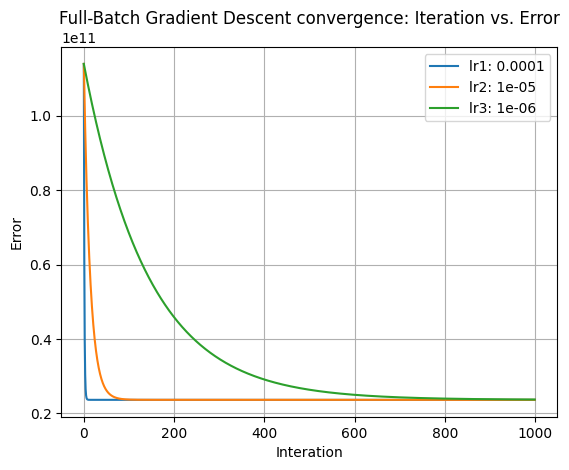

In [180]:
#
plt.plot(errors_lr1, label=f'lr1: {lr1_fbgd}')
plt.plot(errors_lr2, label=f'lr2: {lr2_fbgd}')
plt.plot(errors_lr3, label=f'lr3: {lr3_fbgd}')

plt.title('Full-Batch Gradient Descent convergence: Iteration vs. Error')
plt.xlabel('Interation')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

Для подальшого порівняння вибрано модель, коефіцієнти якої були знайдені за допомогою методу градієнтного спуску (full batch, learning rate: lr1=0.0001), так як передбачення за даною моделлю мають найменшу помилку RMSE.

## LinearRegression from scikit-learn

In [194]:
# Linear regression
lin_reg = LinearRegression()
lin_reg.fit(non_smoker_df.age.to_frame(), non_smoker_df.charges);

In [182]:
# predict target
prediction_lin_reg = lin_reg.predict(non_smoker_df.age.to_frame())

In [183]:
# coefficients found
print('Coefs of sklearn Linear Regression (intercept, coef): ', lin_reg.intercept_, lin_reg.coef_)

Coefs of sklearn Linear Regression (intercept, coef):  -2091.4205565650864 [267.24891283]


In [184]:
# RMSE for Linear regression
rmse_lin_reg = np.sqrt(mean_squared_error(non_smoker_df.charges, prediction_lin_reg))

print(f'RMSE for LinearRegression (sklearn): {rmse_lin_reg}')

RMSE for LinearRegression (sklearn): 4662.505766636395


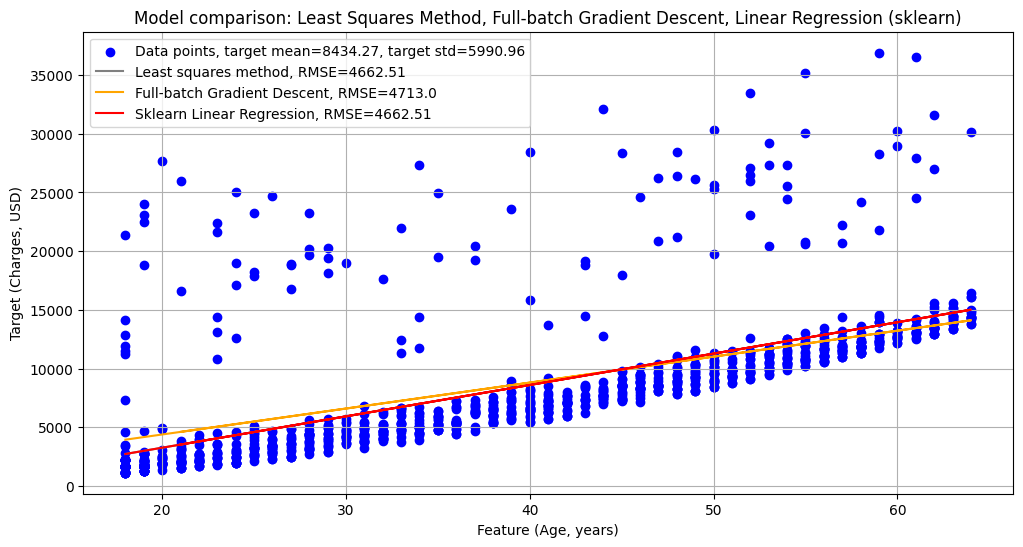

In [185]:
# Plot all models
plt.figure(figsize=(12, 6))
plt.scatter(non_smoker_df.age, non_smoker_df.charges, color='blue', label=f'Data points, target mean={np.round(np.mean(non_smoker_df.charges),2)}, target std={np.round(np.std(non_smoker_df.charges),2)}')
plt.plot(non_smoker_df.age, prediction_lsm, color='grey', label=f'Least squares method, RMSE={np.round(rmse_lsm,2)}')
plt.plot(non_smoker_df.age, prediction_fbgd_lr1, color='orange', label=f'Full-batch Gradient Descent, RMSE={np.round(rmse_fbgd_lr1)}')
plt.plot(non_smoker_df.age, prediction_lin_reg, color='red', label=f'Sklearn Linear Regression, RMSE={np.round(rmse_lin_reg,2)}')

plt.title('Model comparison: Least Squares Method, Full-batch Gradient Descent, Linear Regression (sklearn)')
plt.xlabel('Feature (Age, years)')
plt.ylabel('Target (Charges, USD)')
plt.legend()
plt.grid(True)
plt.show()

In [186]:
# compare coefficients
print('Coefs of Least Squares Method: ', coefs_lsm)
print('Coefs of Full-batch Grad. Descent (b, m): ', b_fbgd_lr1, m_fbgd_lr1)
print('Coefs of sklearn Linear Regression (intercept, coef): ', lin_reg.intercept_, lin_reg.coef_)

Coefs of Least Squares Method:  [-2091.42055657   267.24891283]
Coefs of Full-batch Grad. Descent (b, m):  -41.98126853149978 221.1045843794301
Coefs of sklearn Linear Regression (intercept, coef):  -2091.4205565650864 [267.24891283]


**Висновки**:

Як і очікувалось, метод найменших квадратів та імплементація лінійної регресії знайшли однакові коеіфцієнти для прямої передбачення для даної задачі (червона лінія на графіку дійсна для обох). Так як метод найменших квадратів, що побудований на основі нормальних рівнянь, є методом точної оптимізації (exact optimization), то знайдений розвязок є глобальним мінімумом для даної задачі.З огляду на графік ця модель є також логічною: лінія прогнозування проходить по верхньому краю нижнього щільнішого і чисельнішого кластеру точок тим самим максимально наближаючись до верхнього більш розкиданого, але достатньо сильно впливаючого на цільову змінну кластеру. Градієнтний спуск пропонує дещо гіршу модель для прогнозування.  

 **Завдання 2.** Навчіть модель лінійної регресії з допомогою sklearn оцінювати розмір медичних збори для **курців** за їх віком.
Виведіть
- точність моделі
-  коефіцієнти
-  візуалізуйте модель у вигляді лінії на графіку розсіювання `age` проти `charges`

і зробіть висновки, чи це хороша модель, чи ви б її використовували в компанії?

In [187]:
# select data
smoker_df = medical_df[medical_df.smoker == 'yes']

In [188]:
# setup linear regression
lin_reg_smokers = LinearRegression()
lin_reg_smokers.fit(smoker_df.age.to_frame(), smoker_df.charges);

In [189]:
# predict target
prediction_lin_reg_smokers = lin_reg_smokers.predict(smoker_df.age.to_frame())

In [190]:
# coefficients found
print('Smokers: coefs of sklearn Linear Regression (intercept, coef): ', lin_reg_smokers.intercept_, lin_reg_smokers.coef_)

Smokers: coefs of sklearn Linear Regression (intercept, coef):  20294.128126915966 [305.23760211]


In [191]:
# RMSE for Linear regression
rmse_lin_reg_smokers = np.sqrt(mean_squared_error(smoker_df.charges, prediction_lin_reg_smokers))

print(f'Smokers: RMSE for LinearRegression (sklearn): {rmse_lin_reg_smokers}')

Smokers: RMSE for LinearRegression (sklearn): 10711.00334810241


In [192]:
# statistics of target to evaluate prediction quality
np.mean(smoker_df.charges), np.std(smoker_df.charges)

(np.float64(32050.23183153284), 11520.466706529429)

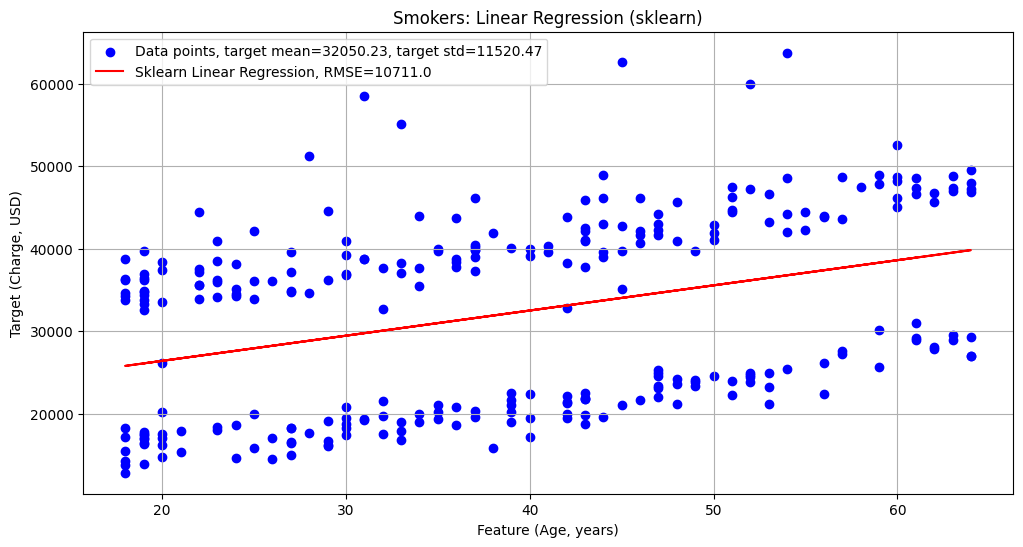

In [193]:
# Plot regression model
plt.figure(figsize=(12, 6))
plt.scatter(smoker_df.age, smoker_df.charges, color='blue', label=f'Data points, target mean={np.round(np.mean(smoker_df.charges),2)}, target std={np.round(np.std(smoker_df.charges),2)}')
plt.plot(smoker_df.age, prediction_lin_reg_smokers, color='red', label=f'Sklearn Linear Regression, RMSE={np.round(rmse_lin_reg_smokers,2)}')

plt.title('Smokers: Linear Regression (sklearn)')
plt.xlabel('Feature (Age, years)')
plt.ylabel('Target (Charge, USD)')
plt.legend()
plt.grid(True)
plt.show()

**Висновки:**

Дана модель лінійної регресії дає грунтовне передбачення для цільової змінної. Якщо оцінювати її помилку RSME за стандартним відхиленням незалежної змінної, то вона є у прийнятних межах. Проте, оцінюючи графічне представлення, можна побачити два наявні кластери в даних і той факт, що дана модель представляє посереднє між цими двома кластерами. Дана модель може бути використана для базового передбачення цільової змінної. Проте, прийнятним було б дослідити склад і природу цих двох кластерів і, як можливий подальший крок, побудувати окремі моделі лінійної регресії для кожного з них для того, щоб моделі більш точно відповідали даним.